Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [129]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [130]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [131]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [132]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [133]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectKBest
import category_encoders as ce

In [134]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

In [135]:
# set data to only one family dwellings
df = df[df['BUILDING_CLASS_CATEGORY']=='01 ONE FAMILY DWELLINGS']

In [136]:
# removed outliers
df = df[((df['SALE_PRICE']>=100000) & (df['SALE_PRICE']<=2000000))]

In [137]:
# stripped ',' from square feet
df['LAND_SQUARE_FEET'] = df['LAND_SQUARE_FEET'].str.replace(',','')

In [138]:
# set square feet to numeric 
df['LAND_SQUARE_FEET'] = pd.to_numeric(df['LAND_SQUARE_FEET'])

In [139]:
# split data into train and test based on cutoff date
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)
cutoff = pd.to_datetime('04/01/2019')
train = df[df['SALE_DATE']<cutoff]
test = df[df['SALE_DATE']>=cutoff]

In [140]:
# look at data.
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,6800,1325.0,1930.0,1,A9,550000,2019-01-01
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,4000,2001.0,1940.0,1,A1,200000,2019-01-01
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,3500,2043.0,1925.0,1,A1,810000,2019-01-02
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,4000,2680.0,1899.0,1,A1,125000,2019-01-02
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,1710,1872.0,1940.0,1,A5,620000,2019-01-02


In [141]:
# looking for cardinality 
df.describe(exclude='number').T

,count,unique,top,freq,first,last
BOROUGH,3164,5,4,1585,NaT,NaT
NEIGHBORHOOD,3164,6,OTHER,3001,NaT,NaT
BUILDING_CLASS_CATEGORY,3164,1,01 ONE FAMILY DWELLINGS,3164,NaT,NaT
TAX_CLASS_AT_PRESENT,3164,2,1,3123,NaT,NaT
BUILDING_CLASS_AT_PRESENT,3164,13,A1,1188,NaT,NaT
ADDRESS,3164,3148,76-04 265TH STREET,2,NaT,NaT
APARTMENT_NUMBER,1,1,RP.,1,NaT,NaT
BUILDING_CLASS_AT_TIME_OF_SALE,3164,11,A1,1189,NaT,NaT
SALE_DATE,3164,91,2019-01-31 00:00:00,78,2019-01-01,2019-04-30


In [142]:
# creating features list and target list, aswell as remove high cardinality columns.
target = 'SALE_PRICE'
high_cardinality = ['SALE_DATE','BUILDING_CLASS_AT_TIME_OF_SALE',
                    'BUILDING_CLASS_AT_PRESENT','ADDRESS','EASE-MENT','APARTMENT_NUMBER',
                    'BUILDING_CLASS_CATEGORY','TAX_CLASS_AT_TIME_OF_SALE']
features = df.columns.drop([target]+high_cardinality)

In [169]:
# onehotencode remaining multicatigorical data.
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

y_train = train[target]
y_test = test[target]

In [170]:
X_train.shape, X_test.shape

((2517, 22), (647, 22))

In [172]:
# running selectkbest from 1 to all features to find the best relationship
testing = []
training = []
ks = range(1, len(X_train.columns)+1)
for k in range(1, len(X_train.columns)+1):
    print(f'{k} features')

    # build selector
    selector = SelectKBest(k=k)
    X_train_selected = selector.fit_transform(X_train,y_train)
    X_test_selected = selector.transform(X_test)
    
    # build training model.
    model = LinearRegression()
    model.fit(X_train_selected, y_train)

    # predict with training data
    y_pred = model.predict(X_train_selected)
    # mae of train set
    mae = mean_absolute_error(y_train, y_pred)
    training.append(mae)
    print(f'Train Mean Absolute Error: ${mae:,.0f}')

    # predict with test data
    y_pred = model.predict(X_test_selected)
    # mae of test set
    mae = mean_absolute_error(y_test, y_pred)
    testing.append(mae)
    print(f'Test Mean Absolute Error: ${mae:,.0f}\n')

1 features
Train Mean Absolute Error: $216,440
Test Mean Absolute Error: $214,282

2 features
Train Mean Absolute Error: $215,268
Test Mean Absolute Error: $214,792

3 features
Train Mean Absolute Error: $212,814
Test Mean Absolute Error: $212,261

4 features
Train Mean Absolute Error: $191,657
Test Mean Absolute Error: $184,289

5 features
Train Mean Absolute Error: $190,143
Test Mean Absolute Error: $184,138

6 features
Train Mean Absolute Error: $189,182
Test Mean Absolute Error: $180,480

7 features
Train Mean Absolute Error: $188,997
Test Mean Absolute Error: $180,886

8 features
Train Mean Absolute Error: $183,764
Test Mean Absolute Error: $176,026

9 features
Train Mean Absolute Error: $183,242
Test Mean Absolute Error: $176,753

10 features
Train Mean Absolute Error: $183,242
Test Mean Absolute Error: $176,753

11 features
Train Mean Absolute Error: $183,242
Test Mean Absolute Error: $176,660

12 features
Train Mean Absolute Error: $183,242
Test Mean Absolute Error: $176,621

1

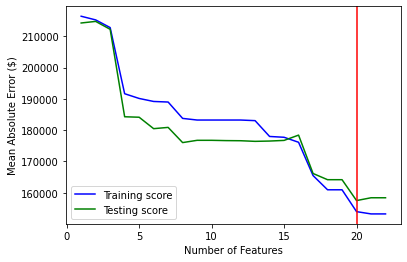

In [173]:
# plot selectkbest, num of features by mae
plt.plot(ks, training, label ='Training score', color='b')
plt.plot(ks, testing, label='Testing score', color='g')
plt.ylabel('Mean Absolute Error ($)')
plt.xlabel('Number of Features')
plt.axvline(x=20, color='r')
plt.legend()
plt.show()

In [204]:
    # build selector
    selector = SelectKBest(k=20)
    X_train_selected = selector.fit_transform(X_train,y_train)
    X_test_selected = selector.transform(X_test)
    
    # build training model.
    model = LinearRegression()
    model.fit(X_train_selected, y_train)

    # predict with training data
    y_pred = model.predict(X_train_selected)
    # mae of train set
    mae = mean_absolute_error(y_train, y_pred)
    
   
    # predict with test data
    y_pred = model.predict(X_test_selected)
    # mae of test set
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f'Test Mean Absolute Error: ${mae:,.0f}\n')

Test Mean Absolute Error: $157,479



In [191]:
# run ridge regression with multiple alpha (bias) types.
for alpha in [0.0001,0.001, 0.01, 0.1, 1.0, 1, 100.0, 1000.0]:
    model = Ridge(alpha=alpha, normalize=True)
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)

    mae = mean_absolute_error(y_pred,y_test)
    print(f'MAE = {mae}, with alpha of {alpha}\n')

MAE = 157459.20977248007, with alpha of 0.0001

MAE = 157400.8122764958, with alpha of 0.001

MAE = 157165.08888898318, with alpha of 0.01

MAE = 157435.77754867016, with alpha of 0.1

MAE = 170808.05792012654, with alpha of 1.0

MAE = 170808.05792012654, with alpha of 1

MAE = 212934.75600882707, with alpha of 100.0

MAE = 214147.57328337478, with alpha of 1000.0



In [203]:
# running ridgecv with multiple alpha types.

alpha = [0.0001,0.001, 0.01, 0.1, 1.0, 1, 100.0, 1000.0]

ridge = RidgeCV(alphas=alpha, normalize=True)
ridge.fit(X_train_selected, y_train)
ridge.alpha_
y_pred = ridge.predict(X_test_selected)
mae = mean_absolute_error(y_pred,y_test)
print(f'Mean absoluete error of:\n{mae}\n\nwith alpha of {ridge.alpha_}')

Mean absoluete error of:
157400.81227648098

with alpha of 0.001


In [206]:
from sklearn.linear_model import Lasso

In [224]:
lasso = Lasso(alpha=100,normalize=True)
lasso.fit(X_train_selected,y_train)
y_pred = lasso.predict(X_test_selected)

mae = mean_absolute_error(y_pred,y_test)
mae

156810.65900240192